In [ ]:
!pip install keras_preprocessing
!pip install keras_applications
# Most Recent One (Suggested)
!pip install git+https://github.com/rcmalli/keras-vggface.git
# Release Version
!pip install keras_vggface
# !pip install opencv-python-headless

In [1]:
import urllib.request

# Download the Haar Cascade classifier file
url = 'https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_alt.xml'
file_name = 'haarcascade_frontalface_alt.xml'
urllib.request.urlretrieve(url,file_name)

('haarcascade_frontalface_alt.xml', <http.client.HTTPMessage at 0x17f854bf8b0>)

In [2]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import warnings
warnings.filterwarnings('ignore')
from keras.optimizers import Adam
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import load_model
from keras_vggface.vggface import VGGFace

from PIL import Image
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras_preprocessing import image as keras_image
from keras.utils import to_categorical
from keras.preprocessing import image

# from google.cloud import storage
import numpy as np
import cv2
import io

# display maximum width of columns
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 10000)

print(tf.__version__)

2.12.0


In [ ]:
# # Load the Drive helper and mount
# from google.colab import drive
# # This will prompt for authorization.
# drive.mount('/content/drive/')
# path_gdrive = '/content/drive/MyDrive/Machine Learning/MLcode/Final Project'
# os.chdir(path_gdrive)
# print(os.getcwd())

Mounted at /content/drive/
/content/drive/MyDrive/Machine Learning/MLcode/Final Project


In [ ]:
# Check if the file is located in the correct directory
# print(os.listdir('./BMI/BMI/Data/'))

['Images', 'data.csv', '.DS_Store', 'final1.ipynb']


In [3]:
# Read the label file
# df_label = pd.read_csv('./BMI/BMI/Data/data.csv')
df_label = pd.read_csv('data.csv')
# change the first column name to id
df_label.rename(columns={'Unnamed: 0':'id'}, inplace=True)
# add a new column to indicate the category of BMI
df_label['bmi_category'] = pd.cut(df_label['bmi'], bins=[16, 18.5, 25, 30, 35, 40, 100], labels=['underweight', 'normal', 'overweight', 'moderately obese', 'severely obese', 'very severely obese'])

df_label


,id,bmi,gender,is_training,name,bmi_category
0,0,34.207396,Male,1,img_0.bmp,moderately obese
1,1,26.453720,Male,1,img_1.bmp,overweight
2,2,34.967561,Female,1,img_2.bmp,moderately obese
3,3,22.044766,Female,1,img_3.bmp,normal
4,4,37.758789,Female,1,img_4.bmp,severely obese
...,...,...,...,...,...,...
4201,4201,34.078947,Male,0,img_4201.bmp,moderately obese
4202,4202,34.564776,Female,0,img_4202.bmp,moderately obese
4203,4203,27.432362,Female,0,img_4203.bmp,overweight
4204,4204,40.492800,Male,0,img_4204.bmp,very severely obese


In [3]:
# set the path to the directory containing the BMP images
# directory_path = './BMI/BMI/Data/Images'
directory_path = 'C:/Users/Richa/MLcode/FinalProject/BMI/BMI/Data/Images'

image_data = []
for filename in os.listdir(directory_path):
    if filename.endswith(".bmp"):
        # load the BMP image using OpenCV
        image = cv2.imread(os.path.join(directory_path, filename))
        # skip empty images
        if image is None or image.size == 0:
            continue
        # append the image data to the list
        image_data.append(image)
#         
print("Total number of images loaded:", len(image_data))


Total number of images loaded: 3963


In [4]:
# create a list of tuples with the name and path for each image
id_path = [(filename, os.path.join(directory_path, filename)) for filename in os.listdir(directory_path) if filename.endswith(".bmp")]

# create a DataFrame with the name and path for each image
image_df = pd.DataFrame(id_path, columns=['name', 'path'])

# merge the image DataFrame with the label DataFrame using the 'name' column
data_df = pd.merge(image_df, df_label, on='name')

# print the resulting DataFrame
print(data_df.head())

           name   
0     img_0.bmp  \
1     img_1.bmp   
2    img_10.bmp   
3   img_100.bmp   
4  img_1000.bmp   

                                                                  path    id   
0     C:/Users/Richa/MLcode/FinalProject/BMI/BMI/Data/Images\img_0.bmp     0  \
1     C:/Users/Richa/MLcode/FinalProject/BMI/BMI/Data/Images\img_1.bmp     1   
2    C:/Users/Richa/MLcode/FinalProject/BMI/BMI/Data/Images\img_10.bmp    10   
3   C:/Users/Richa/MLcode/FinalProject/BMI/BMI/Data/Images\img_100.bmp   100   
4  C:/Users/Richa/MLcode/FinalProject/BMI/BMI/Data/Images\img_1000.bmp  1000   

         bmi gender  is_training         bmi_category  
0  34.207396   Male            1     moderately obese  
1  26.453720   Male            1           overweight  
2  38.732782   Male            1       severely obese  
3  29.834105   Male            1           overweight  
4  42.240827   Male            1  very severely obese  


In [5]:
# split the data into training and validation sets by 'is_training' column

train_df = data_df[data_df['is_training'] == 1]
val_df = data_df[data_df['is_training'] == 0]

# print the shape of the training and validation sets
print(train_df.shape)
print(val_df.shape)


(3210, 7)
(752, 7)


## Model

In [6]:
vggface_model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3))

In [ ]:
# Freeze the VGG layers
from keras.layers import Flatten, Dense, Input, Dropout, Activation, BatchNormalization
for layer in vggface_model.layers:
    layer.trainable = False

x = vggface_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(1)(x)

model = Model(inputs=vggface_model.input, outputs=predictions)


In [ ]:
# compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])


In [7]:
# use the ImageDataGenerator class to load the images from the dataframe
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# create a generator for the training data
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory = directory_path,
    x_col='name',
    y_col='bmi',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    subset='training')

# create a generator for the validation data
val_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory = directory_path,
    x_col='name',
    y_col='bmi',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    subset='validation')

# create a generator for the test data
test_generator = train_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory = directory_path,
    x_col='name',
    y_col='bmi',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    shuffle=False)

Found 2568 validated image filenames.
Found 642 validated image filenames.
Found 752 validated image filenames.


In [ ]:
# fine-tune the model
for layer in model.layers:
    layer.trainable = True

# compile the model
model.compile(optimizer=Adam(lr=0.00001), loss='mse', metrics=['mae', 'mse'])

# fit the model
history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples/train_generator.batch_size,
    epochs=20,
    validation_data=val_generator,
    validation_steps=val_generator.samples/val_generator.batch_size,
    verbose=1)

# save the model
model.save('bmi_model_finetuned3.h5')



Epoch 1/20
80/80 [==============================] - 43s 417ms/step - loss: 96.1880 - mae: 7.3711 - mse: 96.1880 - val_loss: 190.2611 - val_mae: 12.3135 - val_mse: 190.2611
Epoch 2/20
80/80 [==============================] - 29s 359ms/step - loss: 29.1153 - mae: 4.1859 - mse: 29.1153 - val_loss: 819.5257 - val_mae: 27.4648 - val_mse: 819.5257
Epoch 3/20
80/80 [==============================] - 29s 360ms/step - loss: 17.2697 - mae: 3.3158 - mse: 17.2697 - val_loss: 1540.0974 - val_mae: 38.3061 - val_mse: 1540.0974
Epoch 4/20
80/80 [==============================] - 29s 363ms/step - loss: 12.2298 - mae: 2.7516 - mse: 12.2298 - val_loss: 1694.0950 - val_mae: 40.2053 - val_mse: 1694.0950
Epoch 5/20
80/80 [==============================] - 28s 351ms/step - loss: 11.7725 - mae: 2.6602 - mse: 11.7725 - val_loss: 1347.2290 - val_mae: 35.4866 - val_mse: 1347.2290
Epoch 6/20
80/80 [==============================] - 28s 354ms/step - loss: 10.9114 - mae: 2.5603 - mse: 10.9114 - val_loss: 825.9586 -

In [8]:
model_tuned = load_model('bmi_model_finetuned3.h5')

# evaluate the model
model_tuned.evaluate_generator(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)

23/23 [==============================] - 38s 2s/step - loss: 50.8687 - mae: 5.1903 - mse: 50.8687


[50.86874771118164, 5.190300941467285, 50.86874771118164]

In [ ]:
# check the loss and accuracy
print("Loss: ", history.history['loss'][-1])
print("Accuracy: ", history.history['mae'][-1])

Loss:  6.410419464111328
Accuracy:  1.941548228263855


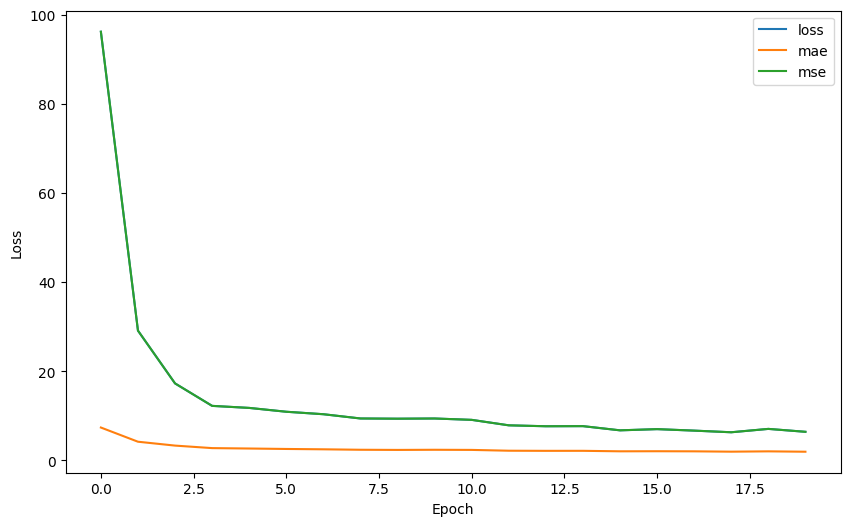

In [ ]:
# plot the loss and accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['mae'], label='mae')
plt.plot(history.history['mse'], label='mse')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
# predict the BMI Value for the test data
y_pred = model_tuned.predict_generator(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)


# print the min and max values of the predicted BMI Value
print(y_pred.min())
print(y_pred.max())


23/23 [==============================] - 37s 2s/step
20.531307
53.51281


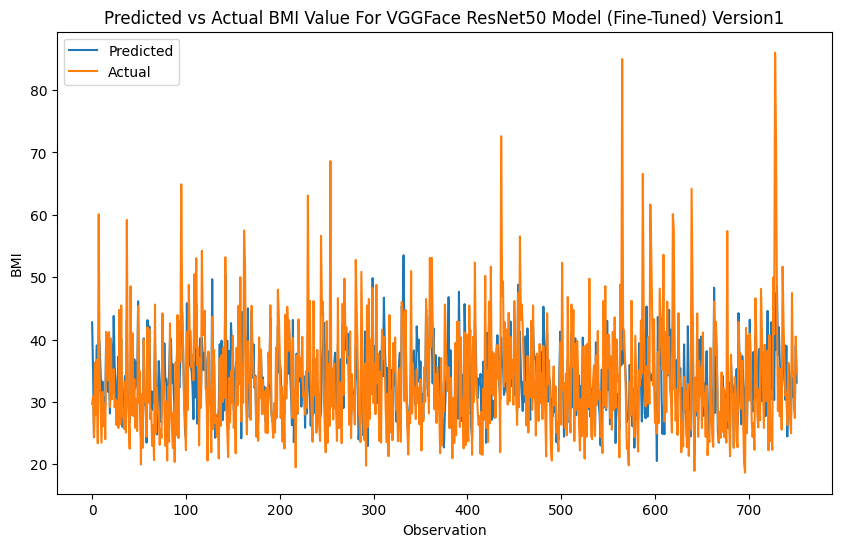

In [31]:
# plot the predicted BMI Value
plt.figure(figsize=(10, 6))
plt.plot(y_pred, label='Predicted')
plt.plot(test_generator.labels, label='Actual')
plt.title('Predicted vs Actual BMI Value For VGGFace ResNet50 Model (Fine-Tuned) Version1')
plt.xlabel('Observation')
plt.ylabel('BMI')
plt.legend()
plt.show()

In [12]:
# check the statistics of the predicted BMI Value: MSE, RMSE, MAE, and R2
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
print("MSE: ", mean_squared_error(test_generator.labels, y_pred))
print("RMSE: ", np.sqrt(mean_squared_error(test_generator.labels, y_pred)))
print("MAE: ", mean_absolute_error(test_generator.labels, y_pred))
print("R2: ", r2_score(test_generator.labels, y_pred))

MSE:  50.868746694193526
RMSE:  7.132232938862382
MAE:  5.190301124783112
R2:  0.4007886389517584


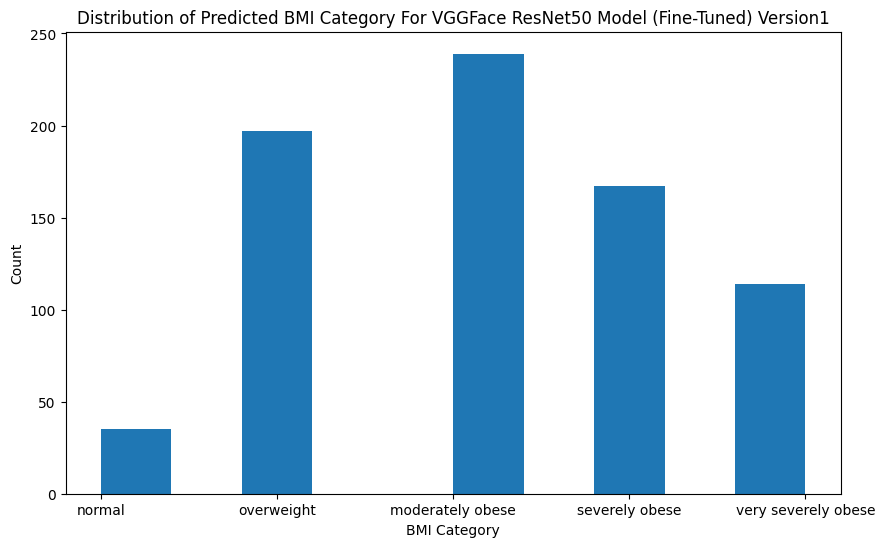

In [37]:
# sort the predicted BMI Value
y_pred_sorted = np.sort(y_pred, axis=0)
y_pred_sorted = y_pred_sorted.reshape(-1, 1)
# create a DataFrame with the associated BMI Category for each predicted BMI Value, underweight: (16 < BMI ≤ 18.5), normal (18.5 < BMI ≤ 25), overweight (25 < BMI ≤ 30), moderately obese (30 < BMI ≤ 35), severely obese (35 < BMI ≤ 40) and severely obese(40 < BMI)
df_pred = pd.DataFrame(y_pred_sorted, columns=['bmi'])
def bmi_category(bmi):
    if bmi <= 18.5:
        return 'underweight'
    elif bmi <= 25:
        return 'normal'
    elif bmi <= 30:
        return 'overweight'
    elif bmi <= 35:
        return 'moderately obese'
    elif bmi <= 40:
        return 'severely obese'
    else:
        return 'very severely obese'
    
df_pred['bmi_category'] = df_pred['bmi'].apply(bmi_category)

# plot the distribution of the predicted BMI Category, using histogram, add title and labels, keep the ditance between each category bar same
plt.figure(figsize=(10, 6))
plt.hist(df_pred['bmi_category'])
plt.title('Distribution of Predicted BMI Category For VGGFace ResNet50 Model (Fine-Tuned) Version1')
plt.xlabel('BMI Category')
plt.ylabel('Count')
plt.show()

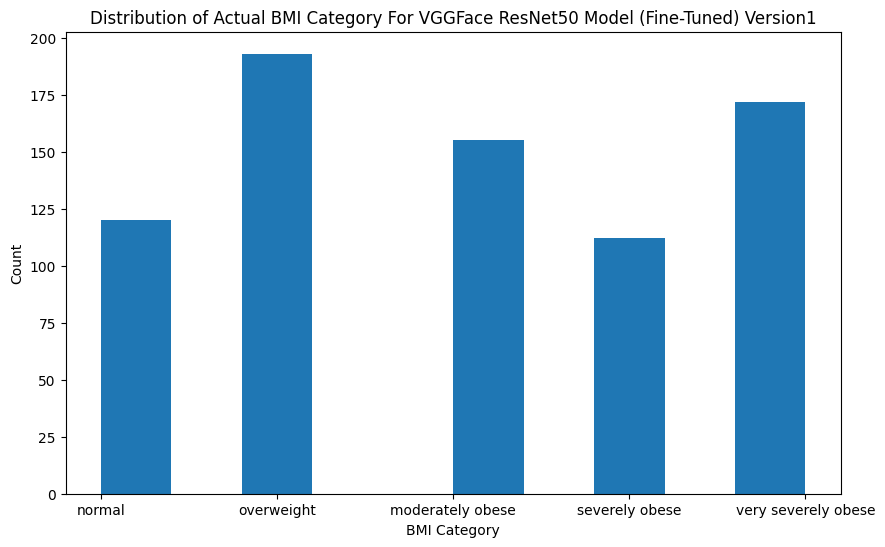

In [38]:
# sort the test_generated labels and create a DataFrame with the associated BMI Category for each test_generated label
y_test_sorted = np.sort(test_generator.labels, axis=0)
y_test_sorted = y_test_sorted.reshape(-1, 1)
df_y_test_sorted = pd.DataFrame(y_test_sorted, columns=['bmi'])

df_y_test_sorted['bmi_category'] = df_y_test_sorted['bmi'].apply(bmi_category)

# plot the distribution of the test_generated BMI Category, using histogram, add title and labels
plt.figure(figsize=(10, 6))
plt.hist(df_y_test_sorted['bmi_category'])
plt.title('Distribution of Actual BMI Category For VGGFace ResNet50 Model (Fine-Tuned) Version1')
plt.xlabel('BMI Category')
plt.ylabel('Count')
plt.show()

In [39]:
#print correlation coefficient
print("Correlation Coefficient: ", np.corrcoef(y_pred.reshape(-1), test_generator.labels)[0, 1])

Correlation Coefficient:  0.6335328791250328
